In [1]:
import scipy.io
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error as mse 
#from jupyterthemes import jtplot
#jtplot.style()

In [2]:
class RBF_kernel:
    
    def __init__(self, parameters = None, dimension = None, bounds = None):
        
        if dimension:
            self._sigma_f = 1 #Needed with self._ for change in @property
            self._length = []
            self._bounds = [(1e-6, 1e6)] #One additional bound is for sigma_f
            for i in range(dimension):
                self._length.append(1)
                self._bounds.append((1e-6, 1e6))
            self._parameters = [self._length, self._sigma_f]
                
        elif parameters is not None:
            self._parameters = parameters
            self._sigma_f = self._parameters[-1] #Needed with self._ for change in @property
            self._length = self._parameters[:-1]
            self._bounds = bounds
            
        else:
            raise ("Specify the lengths scale parameter and bounds or dimensions of the feature space\
            In the latter, default values will be used")
        
    def calculate(self, X1, X2):
        K_mat = {} #Dictionary with matricies of covariances
        for i in range(X1.shape[1]): #for each feature in the dataset
            K_mat["K" + str(i)] = 1/(2*(self._length[i]**2))*(X1[:, i].reshape(-1, 1) - X2[:, i].T)*(X1[:, i].reshape(-1, 1) - X2[:, i].T)
            
        exp_power = np.zeros(shape = (K_mat["K0"].shape[0], K_mat["K0"].shape[1])) #power of the exponent
        for matrix in K_mat:
            exp_power = exp_power + K_mat[matrix]
            
        kernel = self._sigma_f*np.exp(-exp_power) #Compute kernel value
        
        return kernel
    
    @property
    def parameters(self):
        from itertools import chain
        params = list(chain.from_iterable(i if isinstance(i, list) else [i] for i in self._parameters)) #Unlist unnecessary nested list
        return  params
    
    @parameters.setter
    def parameters(self, value):
        self._parameters = value
        self._sigma_f = self._parameters[-1] #Needed with self._ for change in @property
        self._length = self._parameters[:-1]

    @property
    def parameter_bounds(self):
        return self._bounds

In [3]:
class NN_kernel:
    
    def __init__(self, dimension = None, init_aplitude = 0.1, parameters = None, bounds = None):
        
        if dimension:
            self._sigmas = init_aplitude*np.ones(shape = (1, dimension+1))
            self._bounds = []
            for i in range(dimension+1):
                self._bounds.append((1e-1, 0.5))
            self._parameters = self._sigmas
                
        elif parameters is not None:
            self._sigmas = np.array(parameters).reshape(1, -1)
            self._bounds = bounds
            self._parameters = self._sigmas
            
    
    def calculate(self, X1, X2):
        
        covariance = np.zeros(shape = (self._sigmas.shape[1], self._sigmas.shape[1]))
        for i in range(X1.shape[1] + 1):
            covariance[i, i] = self._sigmas[0, i]  
        
        X1 = np.concatenate((np.ones(shape = (X1.shape[0], 1)), X1), axis = 1)
        X2 = np.concatenate((np.ones(shape = (X2.shape[0], 1)), X2), axis = 1)
        numenator = 2*np.dot(X1, np.dot(covariance, X2.T))
        denumenator_1 = 1+2*(np.einsum('ij,ij->i', X1, np.dot(covariance, X1.T).T).reshape(-1, 1)*np.ones(shape = (1, X2.shape[0])))
        denumenator_2 = 1+2*(np.einsum('ij,ij->i', X2, np.dot(covariance, X2.T).T).reshape(1, -1)*np.ones(shape = (X1.shape[0], 1)))
        arg = np.clip(numenator/(np.sqrt(denumenator_1, denumenator_2)), -1, 1) #Clip because the values can be outside (-1, 1)
        kernel = 2/np.pi*np.arcsin(arg)
        
        return kernel
    
    @property
    def parameters(self):
        from itertools import chain
        params = list(chain.from_iterable(i if isinstance(i, list) else [i] for i in self._parameters.tolist()))
        return  params
    
    @parameters.setter
    def parameters(self, value):
        self._parameters = value
        self._sigmas = np.array(self._parameters).reshape(1, -1)
        
    @property
    def parameter_bounds(self):
        """
        Returns a list of bounds of the kernel parameters
        """
        return self._bounds

In [4]:
class Kernel_sum:
    
    def __init__(self, kernels):
        
        self.kernel_list = kernels
        self.kernels = {}
        self._parameters = []
        self._bounds = []
        
        try:
            for kernel in self.kernel_list:
                self.kernels[str(kernel)] = kernel
                self._parameters  += kernel.parameters
                self._bounds += kernel.parameter_bounds
                
        except:
            print ("The kernels must be specified as a list of objects with parameter values")
        
    def calculate(self, X1, X2):
        
        kernel_sum = self.kernels[str(self.kernel_list[0])].calculate(X1, X2)

        for kernel in self.kernel_list:
            if kernel == self.kernel_list[0]:
                continue
            else:
                kernel_sum += self.kernels[str(kernel)].calculate(X1, X2)
        
        return kernel_sum
    
    @property
    def parameters(self):
        from itertools import chain
        params = list(chain.from_iterable(i if isinstance(i, list) else [i] for i in self._parameters)) #Unlist unnecessary nested list
        return  params
    
    @parameters.setter
    def parameters(self, value):
        self._parameters = value
        index = 0
        
        for kernel in self.kernel_list:
            param_length = len(self.kernels[str(kernel)].parameters)
            self.kernels[str(kernel)].parameters = self._parameters[index : index + param_length]
            index += param_length
            
    @property
    def parameter_bounds(self):
        return self._bounds

In [5]:
class GPRegressor:
    
    def __init__(self, kernel, sigma_y, optimize_noise = False, optimizer = "L-BFGS-B"):
        self.kernel = kernel
        self.sigma_y = sigma_y
        self.optimizer = optimizer
        self.optimize_noise = optimize_noise
        
        
    def fit(self, X, y, method = "ML"):
        """
        Fitting methods are "ML" (maximum likelihood) or "CV" (leave-one-out cross validation) 
        """

        def neg_log_likelihood():

            def step(theta):
                
                #If we optimize the noise, we add addtional theta to the vector
                if self.optimize_noise == True:
                    sigma_y = theta[-1] #Noise becomes a tuning parameter
                    self.kernel.parameters = theta[:-1]
                    
                elif self.optimize_noise == False:
                    sigma_y = self.sigma_y #Noise is fixed
                    self.kernel.parameters = theta
                    
                K = self.kernel.calculate(X1 = X, X2 = X) #Compute the kernel

                #Compute Cholesky and alpha parameter for faster computation of the determinant and the inverse(K)
                L = np.linalg.cholesky(K + (sigma_y**2)*np.eye(X.shape[0]))
                m = np.linalg.solve(L, y)
                alpha = np.linalg.solve(L.T, m)
                
                if method == "ML":
                    #Compute the likelihood for the current parameter from the optimizer and return -log_likelihood
                    log_likelihood = 0.5*y.T.dot(alpha) + np.sum(np.log(np.diagonal(L))) + 0.5*X.shape[0]*np.log(2*np.pi)
                
                elif method == "CV":
                    log_likelihood = []
                    for i in range(y.shape[0]):
                        mu_i = y[i] - alpha[i]/(np.dot(np.linalg.inv(L).T, np.linalg.inv(L))[i, i])
                        sigma_i = 1/(np.dot(np.linalg.inv(L).T, np.linalg.inv(L))[i, i])
                        log_lik_i = 1/2*np.log(sigma_i) + ((y[i] - mu_i)**2)/(2*sigma_i) + 1/2*np.log(2*np.pi)
                        log_likelihood.append(log_lik_i)
                        
                    log_likelihood= sum(log_likelihood)
                    
                return log_likelihood
            
            return step

        def optimize():

            from scipy.optimize import minimize
            if self.optimize_noise == True:
                x0 = list(self.kernel.parameters)
                bounds = list(self.kernel.parameter_bounds)
                x0.append(self.sigma_y) #Use the specified noise as an initial guess
                bounds.append((1e-4, 1e4)) #Specify bounds for noise
                
            elif self.optimize_noise == False:
                x0 = self.kernel.parameters
                bounds = self.kernel.parameter_bounds

            optimum = minimize(neg_log_likelihood(), x0 = x0, bounds = bounds, method = self.optimizer)
            best_params, likelihood_value  = optimum.x, optimum.fun 

            return best_params, likelihood_value

        #Run the optimizer
        best_params, likelihood_value = optimize() #Get the optimal parameter values and the likelyhood value
        
        return best_params, likelihood_value
    
    def predict(self, parameters, X_train, y_train, X_test, y_test, sigma_y = None):
        
        if self.optimize_noise == True:
            sigma_y = sigma_y
        elif self.optimize_noise == False:
            sigma_y = self.sigma_y
            
        try:
            if sigma_y == None:
                raise ValueError("Please, specify sigma_y, now it is None")
                
        except ValueError:
            print ("Please, specify sigma_y, now it is None")
        
        self.kernel.parameters = parameters #re-define the kernel parameters
        K = self.kernel.calculate(X1 = X_train, X2 = X_train)
        L = np.linalg.cholesky(K + (sigma_y**2)*np.eye(X_train.shape[0]))
        m = np.linalg.solve(L, y_train)
        alpha = np.linalg.solve(L.T, m)
        K_s = self.kernel.calculate(X_train, X_test)
        mu = np.dot(K_s.T, alpha)
        v = np.linalg.solve(L, self.kernel.calculate(X_train, X_test))
        K_ss = self.kernel.calculate(X_test, X_test)
        s2 = np.diag(K_ss - np.dot(v.T, v)) #diagonal because we are interested in variance
        s = np.sqrt(s2) #standard deviation
        
        return mu, s

In [6]:
def gp_plot(y_true, mu, std):
    plt.figure(1, figsize = (12,7)) 
    X = np.linspace(0, y_true.shape[0]-1, y_true.shape[0])
    plt.plot(y_true, label = "True values", linewidth = 2.0)
    plt.plot(mu, label = "GP mean", linewidth = 2.0)
    plt.gca().fill_between(X, mu.flatten()-3*std.flatten(), mu.flatten()+3*std.flatten(), color = 'grey') #
    plt.legend()

In [13]:
%%time
N = 200
d = 1
n = 100
sigma_y =  0.2

X = np.linspace(-5, 5, N).reshape(-1, d)
y = (np.sin(0.9*X[:, 0]) + random.randint(0, 10)*np.sin(0.9*X[:, d-1])).reshape(-1, 1) + sigma_y*np.random.randn(int(N/d), 1)

X_test = np.linspace(-10, 15, n).reshape(-1, d)
y_test = (np.sin(0.5*X_test[:, 0]) + random.randint(0, 10)*np.sin(0.9*X_test[:, d-1])).reshape(-1, 1) + sigma_y*np.random.randn(int(n/d), 1)

#k1 = NN_kernel(dimension = X.shape[1], init_aplitude = 0.5)
k1 = RBF_kernel(dimension = X.shape[1])
#k2 = RBF_kernel(dimension = X.shape[1])
#k = Kernel_sum([k1, k2])
gpr = GPRegressor(kernel = k1, sigma_y = 0.05, optimize_noise = True)

best_params, llh = gpr.fit(X = X, y = y, method = "ML")
mu_train, s_train = gpr.predict(parameters = best_params[:-1], X_train = X, X_test = X, y_train = y, y_test = y, sigma_y = best_params[-1])
mu_test, s_test = gpr.predict(parameters = best_params[:-1], X_train = X, X_test = X_test, y_train = y, y_test = y_test, sigma_y = best_params[-1])

Wall time: 1.14 s


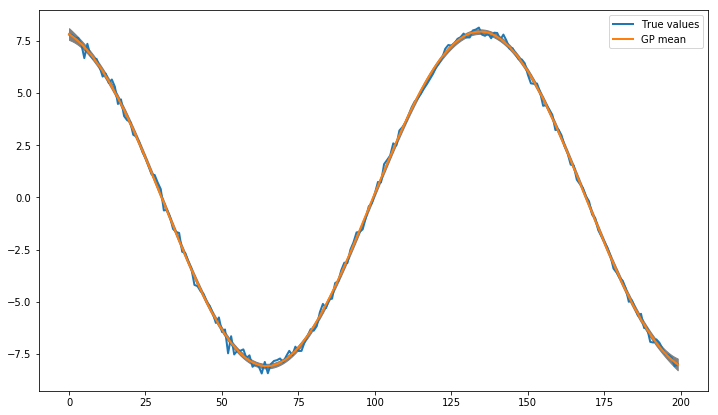

In [14]:
gp_plot(y, mu_train, s_train)

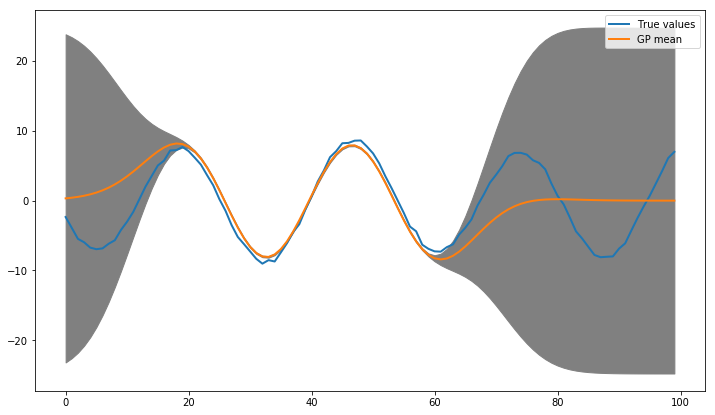

In [15]:
gp_plot(y_test, mu_test, s_test)